In [21]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# FUNCTION

In [22]:
IMAGE_SIZE = 256
NUM_CLASSES = 6

In [23]:
def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE], method='nearest')
        image = tf.cast(image, dtype=tf.float32)
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = image / 255
        image = tf.cast(image, dtype=tf.float32)
    return image

def load_data(image_list, mask_list):
    img = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return img, mask

def data_generator(image_list, mask_list, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    return dataset

In [24]:
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Dropout, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.models import Model

In [25]:
def UNET(num_classes, shape):

    """ ENCODE_BLOCK """

    INPUT = Input(shape)

    conv_1_down = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(INPUT)
    conv_1_down = BatchNormalization()(conv_1_down)
    conv_1_down = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv_1_down)
    conv_1_down = BatchNormalization()(conv_1_down)

    maxpool1 = MaxPooling2D(pool_size=2)(conv_1_down)
    conv_2_down = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(maxpool1)
    conv_2_down = BatchNormalization()(conv_2_down)
    conv_2_down = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv_2_down)
    conv_2_down = BatchNormalization()(conv_2_down)
    
    maxpool2 = MaxPooling2D(pool_size=2)(conv_2_down)
    conv_3_down = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(maxpool2)
    conv_3_down = BatchNormalization()(conv_3_down)
    conv_3_down = Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv_3_down)
    conv_3_down = BatchNormalization()(conv_3_down)
    
    maxpool3 = MaxPooling2D(pool_size=2)(conv_3_down)
    conv_4_down = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(maxpool3)
    conv_4_down = BatchNormalization()(conv_4_down)
    conv_4_down = Conv2D(filters=256, kernel_size=3, strides=1, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv_4_down)
    conv_4_down = BatchNormalization()(conv_4_down)
    
    maxpool4 = MaxPooling2D(pool_size=2)(conv_4_down)
    conv_5_down = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(maxpool4)
    conv_5_down = BatchNormalization()(conv_5_down)
    conv_5_down = Conv2D(filters=512, kernel_size=3, strides=1, padding='same', activation = 'relu', kernel_initializer = 'he_normal')(conv_5_down)
    conv_5_down = BatchNormalization()(conv_5_down)

    drop = Dropout(0.5)(conv_5_down)

    """ DECODE_BLOCK """

    conv_4_up = Conv2D(256, 2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop))
    concat1 = Concatenate()([conv_4_down, conv_4_up])
    conv_4_up = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(concat1)
    conv_4_up = BatchNormalization()(conv_4_up)
    conv_4_up = Conv2D(256, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(conv_4_up)
    conv_4_up = BatchNormalization()(conv_4_up)

    conv_3_up = Conv2D(128, 2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_4_up))
    concat2 = Concatenate()([conv_3_up, conv_3_down])
    conv_3_up = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(concat2)
    conv_3_up = BatchNormalization()(conv_3_up)
    conv_3_up = Conv2D(128, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(conv_3_up)
    conv_3_up = BatchNormalization()(conv_3_up)

    conv_2_up = Conv2D(64, 2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_3_up))
    concat3 = Concatenate()([conv_2_up, conv_2_down])
    conv_2_up = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(concat3)
    conv_2_up = BatchNormalization()(conv_2_up)
    conv_2_up = Conv2D(64, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(conv_2_up)
    conv_2_up = BatchNormalization()(conv_2_up)

    conv_1_up = Conv2D(32, 2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv_2_up))
    concat4 = Concatenate()([conv_1_up, conv_1_down])
    conv_1_up = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(concat4)
    conv_1_up = BatchNormalization()(conv_1_up)
    conv_1_up = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(conv_1_up)
    conv_1_up = BatchNormalization()(conv_1_up)

    conv_1_up = Conv2D(32, 3, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(conv_1_up)

    OUTPUT = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv_1_up)

    model = Model(inputs=INPUT, outputs=OUTPUT)

    return model

# GET TRAIN DATA

In [26]:
train_images_0 = []
for i in os.listdir('leftImg8bit\\train'):
    folder_path = 'leftImg8bit\\train\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\train\\' + i + '\\' + j
        train_images_0.append(img_path)

train_images_0 = sorted(train_images_0)
print(len(train_images_0))

2975


In [27]:
train_images_light_1 = []
for i in os.listdir('leftImg8bit\\train_light_1'):
    folder_path = 'leftImg8bit\\train_light_1\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\train_light_1\\' + i + '\\' + j
        train_images_light_1.append(img_path)

train_images_light_1 = sorted(train_images_light_1)
print(len(train_images_light_1))

2975


In [28]:
train_images_light_2 = []
for i in os.listdir('leftImg8bit\\train_light_2'):
    folder_path = 'leftImg8bit\\train_light_2\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\train_light_2\\' + i + '\\' + j
        train_images_light_2.append(img_path)

train_images_light_2 = sorted(train_images_light_2)
print(len(train_images_light_2))

2975


In [29]:
train_images_night_1 = []
for i in os.listdir('leftImg8bit\\train_night_1'):
    folder_path = 'leftImg8bit\\train_night_1\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\train_night_1\\' + i + '\\' + j
        train_images_night_1.append(img_path)

train_images_night_1 = sorted(train_images_night_1)
print(len(train_images_night_1))

2975


In [30]:
train_images_night_2 = []
for i in os.listdir('leftImg8bit\\train_night_2'):
    folder_path = 'leftImg8bit\\train_night_2\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\train_night_2\\' + i + '\\' + j
        train_images_night_2.append(img_path)

train_images_night_2 = sorted(train_images_night_2)
print(len(train_images_night_2))

2975


In [31]:
train_masks_0 = []
train_mask_light_1 = []
train_mask_light_2 = []
train_mask_night_1 = []
train_mask_night_2 = []
for i in os.listdir('mask\\train'):
    train_masks_0.append('mask\\train\\' + i)
    train_mask_light_1.append('mask\\train\\' + i)
    train_mask_light_2.append('mask\\train\\' + i)
    train_mask_night_1.append('mask\\train\\' + i)
    train_mask_night_2.append('mask\\train\\' + i)

train_masks_0 = sorted(train_masks_0)
train_mask_light_1 = sorted(train_mask_light_1)
train_mask_light_2 = sorted(train_mask_light_2)
train_mask_night_1 = sorted(train_mask_night_1)
train_mask_night_2 = sorted(train_mask_night_2)
print(len(train_masks_0))
print(len(train_mask_light_1))
print(len(train_mask_light_2))
print(len(train_mask_night_1))
print(len(train_mask_night_2))

2975
2975
2975
2975
2975


In [32]:
train_images = train_images_0 #+ train_images_light_1 + train_images_light_2 + train_images_night_1 + train_images_night_2
train_masks = train_masks_0 #+ train_mask_light_1 + train_mask_light_2 + train_mask_night_1 + train_mask_night_2

# GET VALID DATA

In [33]:
val_images = []
for i in os.listdir('leftImg8bit\\val'):
    folder_path = 'leftImg8bit\\val\\' + i
    files = os.listdir(folder_path)
    for j in files:
        img_path = 'leftImg8bit\\val\\' + i + '\\' + j
        val_images.append(img_path)

val_images = sorted(val_images)
print(len(val_images))

500


In [34]:
val_masks = []
for i in os.listdir('mask\\val'):
    val_masks.append('mask\\val\\' + i)

val_masks = sorted(val_masks)
print(len(val_masks))

500


# GENERATOR

In [35]:
train_dataset = data_generator(train_images, train_masks, 4)
val_dataset = data_generator(val_images, val_masks, 2)

print("Train Dataset:", train_dataset)
print("Val Dataset:", val_dataset)

Train Dataset: <BatchDataset element_spec=(TensorSpec(shape=(4, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 256, 256, 1), dtype=tf.float32, name=None))>
Val Dataset: <BatchDataset element_spec=(TensorSpec(shape=(2, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 256, 256, 1), dtype=tf.float32, name=None))>


In [36]:
input_shape = (256, 256, 3)
model = UNET(num_classes=6, shape=input_shape)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 256, 256, 32  128        ['conv2d_24[0][0]']              
 ormalization)                  )                                                           

In [37]:
print(len(train_images))
print(len(val_images))

2975
500


In [38]:
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# sử dụng callback (Nếu trong 5 epoch liên tiếp mà 'val_loss' không giảm thì stop 
# và trả về weight của Epoch (Stopped Epoch = Patience))
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=loss, metrics=['accuracy'])

history = model.fit(train_dataset, epochs=20, validation_data=val_dataset, verbose=1)

Epoch 1/20
743/743 [==============================] - 246s 322ms/step - loss: 0.3818 - accuracy: 0.8650 - val_loss: 0.6003 - val_accuracy: 0.8311
Epoch 2/20
743/743 [==============================] - 238s 320ms/step - loss: 0.2907 - accuracy: 0.9007 - val_loss: 0.4899 - val_accuracy: 0.8602
Epoch 3/20
743/743 [==============================] - 252s 339ms/step - loss: 0.2554 - accuracy: 0.9140 - val_loss: 0.4968 - val_accuracy: 0.8681
Epoch 4/20
743/743 [==============================] - 238s 320ms/step - loss: 0.2305 - accuracy: 0.9228 - val_loss: 0.8842 - val_accuracy: 0.7292
Epoch 5/20
743/743 [==============================] - 238s 320ms/step - loss: 0.2195 - accuracy: 0.9270 - val_loss: 0.3880 - val_accuracy: 0.8884
Epoch 6/20
743/743 [==============================] - 238s 320ms/step - loss: 0.1928 - accuracy: 0.9350 - val_loss: 0.3029 - val_accuracy: 0.9075
Epoch 7/20
743/743 [==============================] - 239s 321ms/step - loss: 0.1719 - accuracy: 0.9419 - val_loss: 0.2759 -

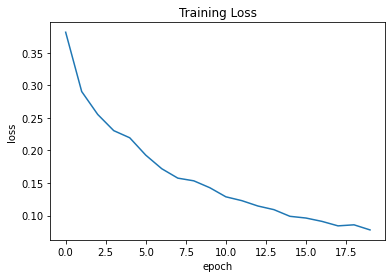

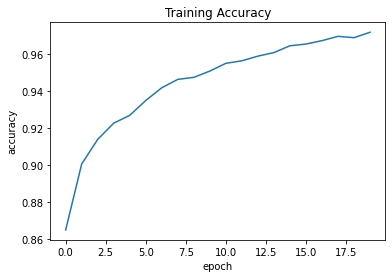

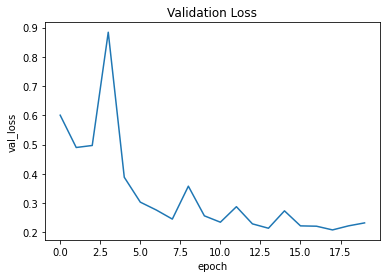

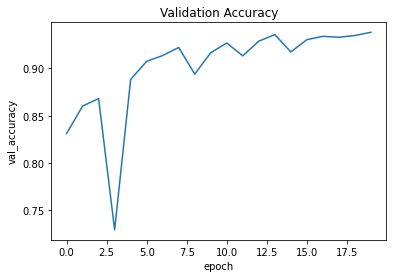

In [39]:
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

In [40]:
model.save('D:\\CV\\model_Unet.h5')